In [ ]:
https://github.com/marybun/machine_learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math

In [2]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

dt = 0.01
T = 8
t = np.arange(0,T+dt,dt)
beta = 8/3
sigma = 10.0
rho =28
# Define the Lorenz equations
def lorenz_deriv(x_y_z, t0, rho=rho, sigma=sigma, beta=beta):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

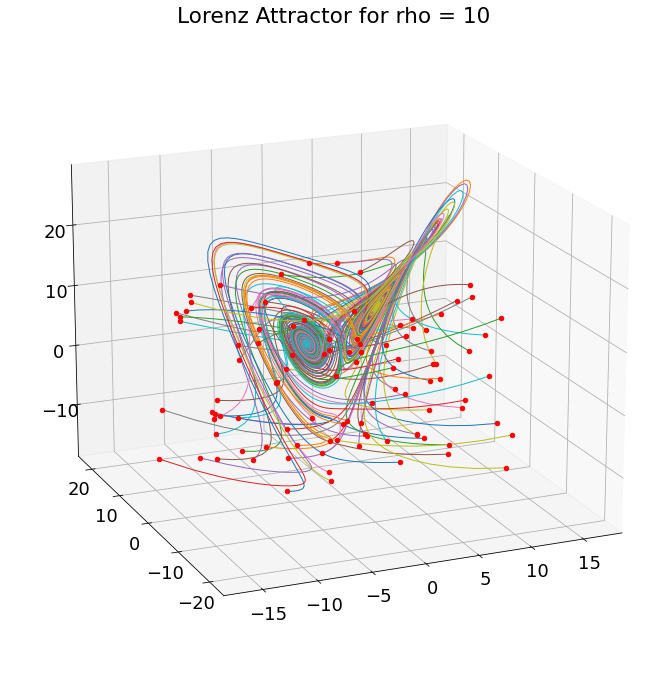

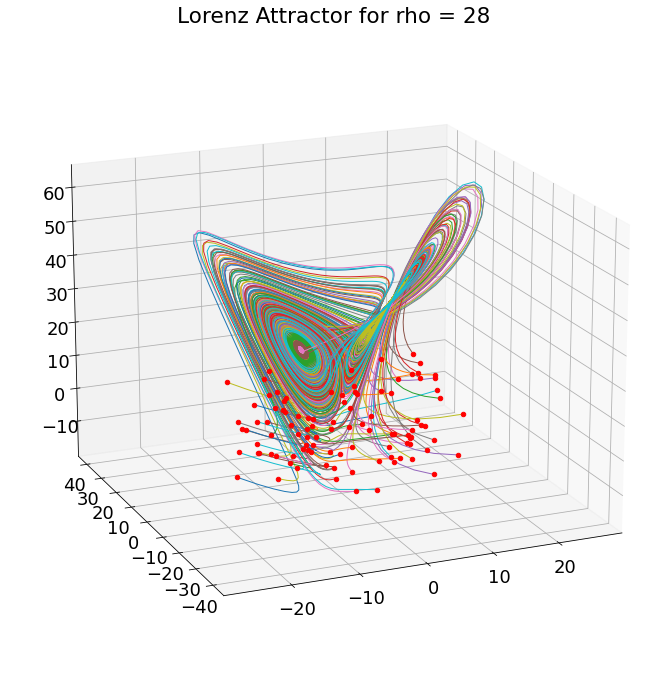

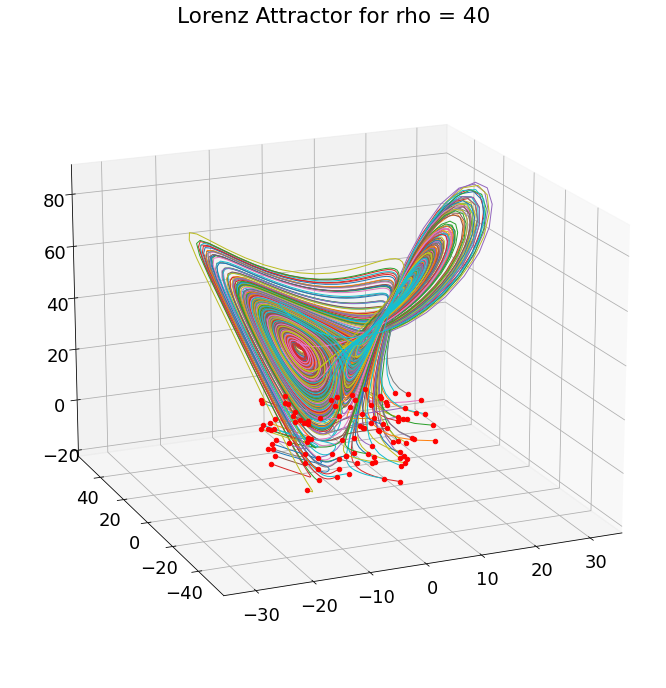

nn_input_train: (240000, 3)
nn_output_train: (240000, 3)


In [3]:
rho_train = [10, 28, 40]
np.random.seed(123) ## Set once before multiple calls to random() function
# Define a function to generate training data for the neural network
def generate_data(delta_t, rho):
    # Generate random initial conditions
    x0 = -15 + 30 * np.random.random((100, 3))

    # Integrate the Lorenz equations to generate training data
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t, args = (rho, sigma, beta))
                    for x0_j in x0])

    fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
    nn_input = np.zeros((100*(len(t)-1),3))
    nn_output = np.zeros_like(nn_input)

    for j in range(100):
        nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
        nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]
        x, y, z = x_t[j,:,:].T
        ax.plot(x, y, z,linewidth=1)
        ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
        plt.title('Lorenz Attractor for rho = ' + str(rho))

    ax.view_init(18, -113)
    plt.show()
    return x0, nn_input, nn_output

# Generate training data using rho_train values
nn_input_train, nn_output_train = [], []
for rho_train_value in rho_train:
    x0, input_data, output_data = generate_data(dt, rho_train_value)
    nn_input_train.append(input_data)
    nn_output_train.append(output_data)

nn_input_train = np.concatenate(nn_input_train)
nn_output_train = np.concatenate(nn_output_train)
print("nn_input_train:", nn_input_train.shape)
print("nn_output_train:", nn_output_train.shape)

In [4]:
from torch.utils.data import DataLoader, Dataset

class TrainDataset(Dataset):
    def __init__(self, input_data, output_data):
        self.input = torch.tensor(input_data, dtype=torch.float32)
        self.output = torch.tensor(output_data, dtype=torch.float32) 
        self.n_samples=self.input.shape[0]
    def __getitem__(self, index):
        return self.input[index], self.output[index]
    def __len__(self):
        return self.n_samples

In [54]:
# Create the neural network and optimizer
def train_NN(model, input_train, output_train, num_epochs = 100, batch_size = 128):
    print(f'batch_size: {batch_size}')
    dataset = TrainDataset(input_train, output_train)   
    total_samples = len(dataset)
    print(f'total_samples: {total_samples}')
    num_iterations = math.ceil(total_samples/batch_size)
    print(f'n_iterations: {num_iterations}')

    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
   
    optimizer = torch.optim.Adam(model.parameters())
    mse=np.zeros(num_epochs)
    loss_fn = nn.MSELoss()
    
    for epoch in range(num_epochs):
        for i, (inputs, outputs) in enumerate(dataloader):
            optimizer.zero_grad()
            pred = model(inputs)
            loss = loss_fn(pred, outputs)
            loss.backward()
            optimizer.step()
            mse[epoch]=loss
            if((i+1) % 100 == 0):
                print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{num_iterations},  MSELoss={mse[epoch]:0.4f}')
    plt.plot(range(num_epochs),mse)
    plt.title("Error")
    plt.ylabel("MSE")
    plt.xlabel("Epoch")
    return model    

batch_size: 128
total_samples: 240000
n_iterations: 1875
epoch 1/100, step 100/1875,  MSELoss=1.4684
epoch 1/100, step 200/1875,  MSELoss=0.5185
epoch 1/100, step 300/1875,  MSELoss=0.1991
epoch 1/100, step 400/1875,  MSELoss=0.0792
epoch 1/100, step 500/1875,  MSELoss=0.0991
epoch 1/100, step 600/1875,  MSELoss=0.2105
epoch 1/100, step 700/1875,  MSELoss=0.0632
epoch 1/100, step 800/1875,  MSELoss=0.0734
epoch 1/100, step 900/1875,  MSELoss=0.0876
epoch 1/100, step 1000/1875,  MSELoss=0.0918
epoch 1/100, step 1100/1875,  MSELoss=0.0673
epoch 1/100, step 1200/1875,  MSELoss=0.0507
epoch 1/100, step 1300/1875,  MSELoss=0.0581
epoch 1/100, step 1400/1875,  MSELoss=0.0639
epoch 1/100, step 1500/1875,  MSELoss=0.0736
epoch 1/100, step 1600/1875,  MSELoss=0.0774
epoch 1/100, step 1700/1875,  MSELoss=0.0599
epoch 1/100, step 1800/1875,  MSELoss=0.0783
epoch 2/100, step 100/1875,  MSELoss=0.0584
epoch 2/100, step 200/1875,  MSELoss=0.0748
epoch 2/100, step 300/1875,  MSELoss=0.1001
epoch 2/10

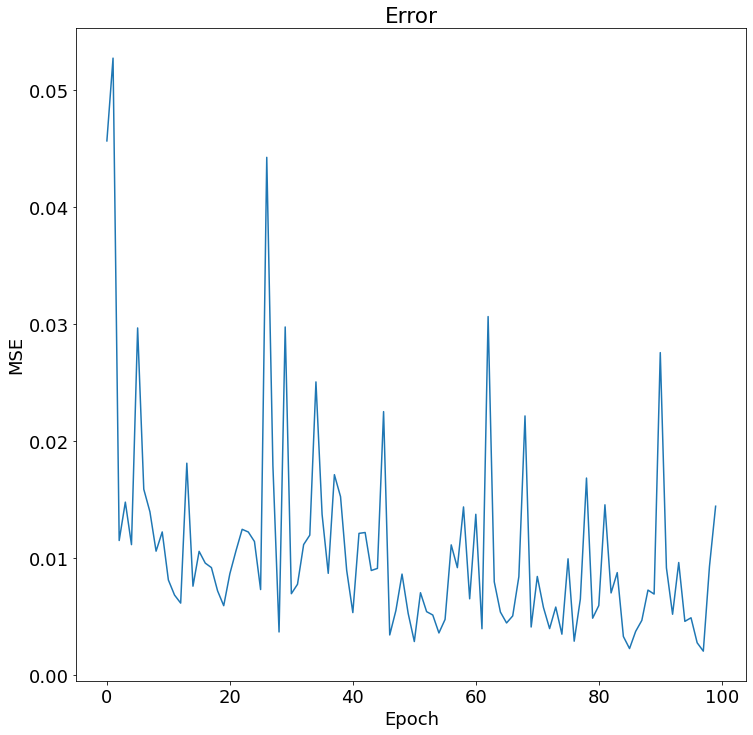

In [87]:
# Define a neural network to predict the next state given the current state
class LorenzNN(nn.Module):
    def __init__(self):
        super(LorenzNN, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
# Train the neural network using all rho_train values
model = LorenzNN()
model = train_NN(model, input_train=nn_input_train, output_train=nn_output_train,num_epochs=100)

In [56]:
# Define function to predict and show how well the model performs 
# for a specific rho not in the training set
def model_predict(model, rho):
    x0 = -15 + 20 * np.random.random((2,3))
    x_t = integrate.odeint(lorenz_deriv, x0[0,:], t, args = (rho, sigma, beta))

    ynn = np.zeros((len(t),3))
    ynn[0,:]=x0[0,]
    print("x0     :", ynn[0,:])
    with torch.no_grad():
        y0 = torch.tensor(ynn[0,:], dtype=torch.float32)
        for j in range(len(t)-1):
            y1 = model(y0)
            y0 = y1
            ynn[j+1,:] = y1.detach().numpy()
            if((j+1) % 100 == 0):
                print("predict:",ynn[j+1,:])
                print("actual :", x_t[j,])
    print(x0.shape)
    print(ynn.shape)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x_t[:,0], x_t[:,1], x_t[:,2], linewidth=1)
    ax.plot(ynn[:,0],ynn[:,1],ynn[:,2],'g.')
    ax.scatter(x0[0,0],x0[0,1],x0[0,2],'r')
    plt.title(type(model).__name__ + ' Prediction of Lorenz Attractor, rho=' + str(rho))
    ax.view_init(18, -113)
    plt.show()

    fig = plt.figure()

    ax = fig.add_subplot(3,1,1)
    ax.plot(t, x_t[:,0], linewidth=1)
    ax.plot(t, ynn[:,0],'g.')
    plt.title(type(model).__name__ + ' Prediction of Lorenz Attractor, rho= ' + str(rho))
    ax.set_ylabel("x(t)")

    ax = fig.add_subplot(3,1,2)
    ax.plot(t, x_t[:,1], linewidth=1)
    ax.plot(t, ynn[:,1],'g.')
    ax.set_ylabel("y(t)")
            
    ax = fig.add_subplot(3,1,3)
    ax.plot(t, x_t[:,2], linewidth=1)
    ax.plot(t, ynn[:,2],'g.')
    ax.set_ylabel("z(t)")
    ax.set_xlabel("t")
    plt.show()

x0     : [ -6.60982767 -12.40678281 -12.80887754]
predict: [-9.49210167 -5.1992445  43.3349762 ]
actual : [5.20366208 7.30800286 9.87366667]
predict: [-12.74423885  -8.91106033  47.10952759]
actual : [ 8.78465345 10.2451121  16.2073471 ]
predict: [-14.27108383 -15.79808807  44.33347702]
actual : [ 7.44251083  5.5502644  19.47192625]
predict: [-11.45685291 -16.73424339  34.84004593]
actual : [ 4.89965665  4.37743614 15.36302265]
predict: [ -7.26178694 -11.3068409   30.16056633]
actual : [ 5.73480499  6.58284684 13.64861062]
predict: [-4.87399721 -5.67341471 32.72826767]
actual : [ 7.47422307  7.85883346 16.37080654]
predict: [-6.83461523 -1.88644874 41.26493835]
actual : [ 6.67139428  5.99455562 17.1649123 ]
predict: [-16.58134651 -18.79050636  47.75687027]
actual : [ 5.89764667  5.8943103  15.3829582 ]
(2, 3)
(801, 3)


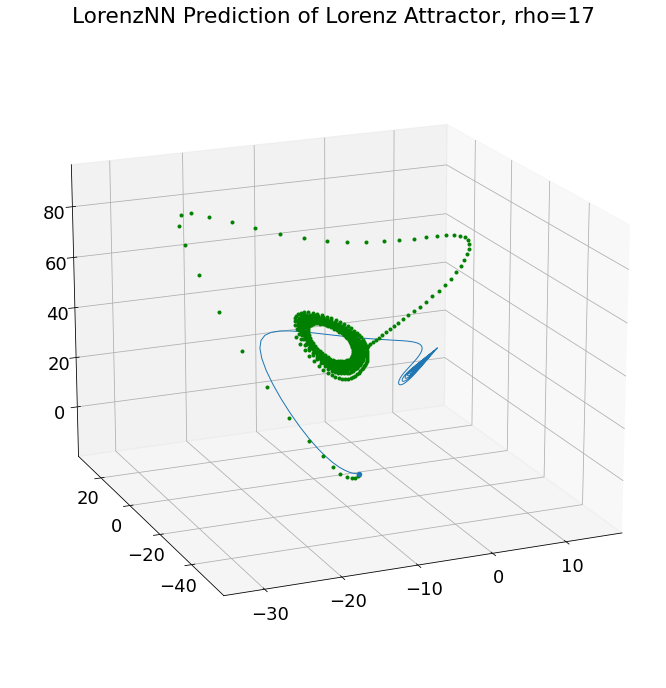

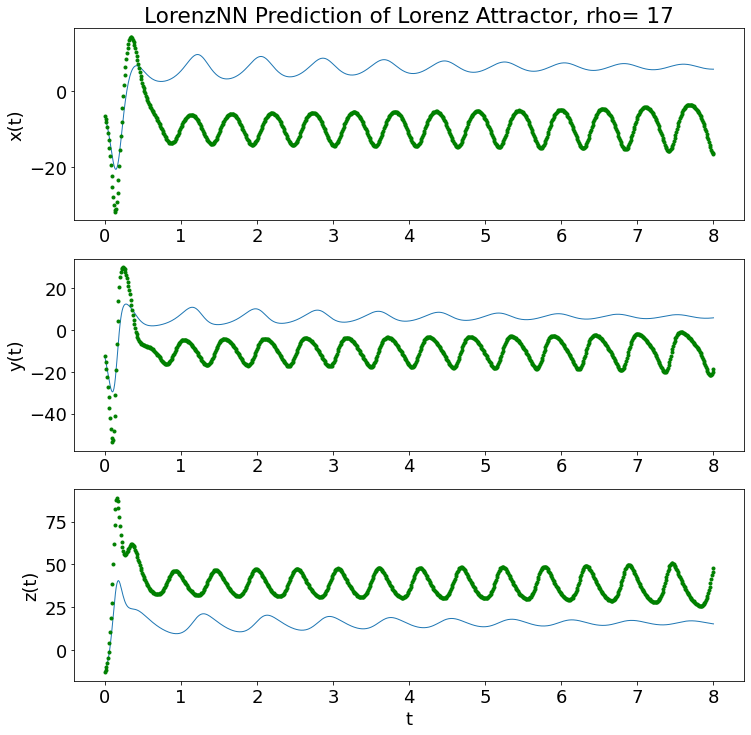

x0     : [-10.94872196  -8.77685618  -3.83738591]
predict: [-0.7813223  -2.31218219 23.4258709 ]
actual : [13.08981788  9.38852804 42.4748857 ]
predict: [15.2852726  13.12926197 47.29378128]
actual : [ 4.2318983   7.11745865 19.4855665 ]
predict: [-0.3773858  -1.68355489 23.45551491]
actual : [-16.85738435  -8.86721763  51.0377931 ]
predict: [13.05208111 19.98607254 32.75867462]
actual : [ 4.21732434  7.2127527  18.98853335]
predict: [-16.58544731 -17.38458061  38.65148926]
actual : [-13.35527366  -1.93503776  48.40706596]
predict: [ 1.84242547  3.95917797 30.1129818 ]
actual : [ 1.33511852  2.30398632 16.90966602]
predict: [-0.68486953 -1.24351239 11.14034557]
actual : [-10.15686146  -3.95648038  40.90910042]
predict: [14.87098408 18.69808197 40.2705307 ]
actual : [-4.34735082 -7.83123782 17.32667685]
(2, 3)
(801, 3)


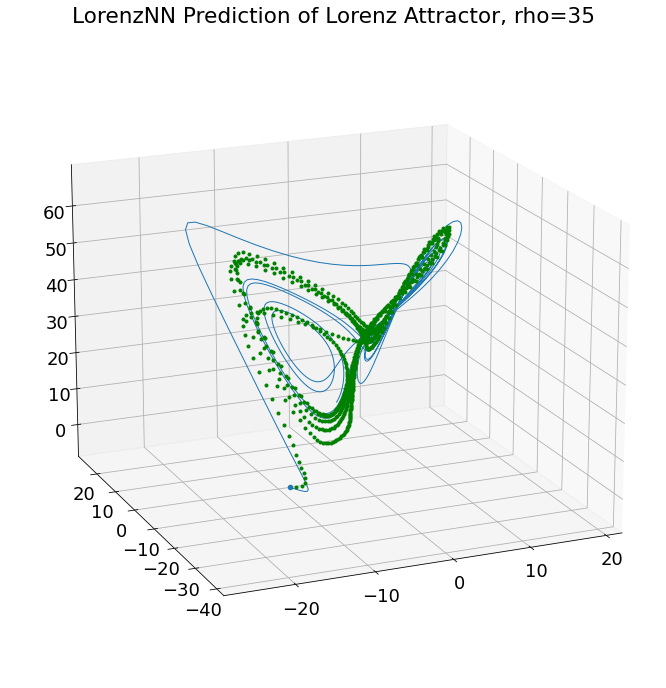

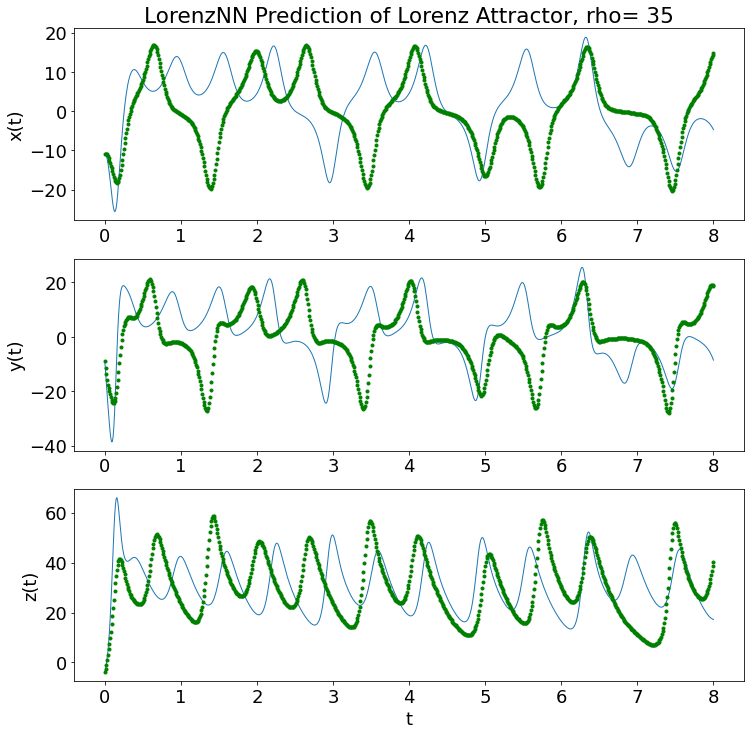

In [57]:
# Now see how well the NN works for future state prediction 
np.random.seed(133) ## Set once before multiple calls to random() function
model_predict(model, rho = 17)
model_predict(model, rho = 35)

batch_size: 128
total_samples: 240000
n_iterations: 1875


c:\Users\Mary\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([128, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 1/100, step 100/1875,  MSELoss=183.3652
epoch 1/100, step 200/1875,  MSELoss=137.9100
epoch 1/100, step 300/1875,  MSELoss=122.3648
epoch 1/100, step 400/1875,  MSELoss=119.2085
epoch 1/100, step 500/1875,  MSELoss=114.9798
epoch 1/100, step 600/1875,  MSELoss=107.4336
epoch 1/100, step 700/1875,  MSELoss=96.7076
epoch 1/100, step 800/1875,  MSELoss=112.4648
epoch 1/100, step 900/1875,  MSELoss=99.5083
epoch 1/100, step 1000/1875,  MSELoss=107.7756
epoch 1/100, step 1100/1875,  MSELoss=116.5656
epoch 1/100, step 1200/1875,  MSELoss=107.6038
epoch 1/100, step 1300/1875,  MSELoss=132.6496
epoch 1/100, step 1400/1875,  MSELoss=96.5083
epoch 1/100, step 1500/1875,  MSELoss=111.8298
epoch 1/100, step 1600/1875,  MSELoss=98.5018
epoch 1/100, step 1700/1875,  MSELoss=114.6932
epoch 1/100, step 1800/1875,  MSELoss=109.7361
epoch 2/100, step 100/1875,  MSELoss=122.1034
epoch 2/100, step 200/1875,  MSELoss=127.8020
epoch 2/100, step 300/1875,  MSELoss=111.1351
epoch 2/100, step 400/1875,  

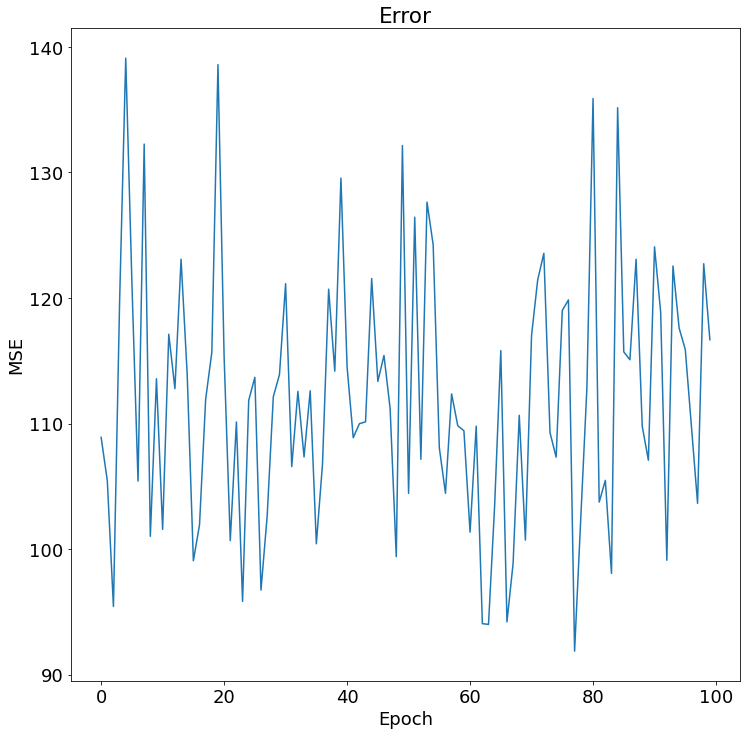

In [58]:
# Define a neural network to predict the next state given the current state
class LorenzLSTM(nn.Module):
    def __init__(self):
        super(LorenzLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=3, hidden_size=64, num_layers=2, batch_first=True)
        self.fc = nn.Linear(64, 3)

    def forward(self, x):
        _, (h, _) = self.lstm(x)
        x = self.fc(h[-1])
        return x
    
# Train the neural network using all rho_train values
model = LorenzLSTM()
model = train_NN(model, input_train=nn_input_train, output_train=nn_output_train, num_epochs=100)

In [59]:
def LSTM_predict(model, rho):
    x0 = -15 + 20 * np.random.random((2, 3))
    x_t = integrate.odeint(lorenz_deriv, x0[0, :], t, args=(rho, sigma, beta))

    ynn = np.zeros((len(t), 3))
    ynn[0, :] = x0[0, :]
    print("x0     :", ynn[0, :])
    with torch.no_grad():
        y0 = torch.tensor(ynn[0, :], dtype=torch.float32)
        for j in range(len(t) - 1):
            y1 = model(y0.unsqueeze(0)) 
            y0 = y1.squeeze()
            ynn[j + 1, :] = y1.detach().numpy().squeeze()
            if (j + 1) % 100 == 0:
                print("predict:", ynn[j + 1, :])
                print("actual :", x_t[j, :])
    print(x0.shape)
    print(ynn.shape)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot(x_t[:, 0], x_t[:, 1], x_t[:, 2], linewidth=1)
    ax.plot(ynn[:, 0], ynn[:, 1], ynn[:, 2], "g.")
    ax.scatter(x0[0, 0], x0[0, 1], x0[0, 2], "r")
    plt.title(
        type(model).__name__ + " Prediction of Lorenz Attractor, rho=" + str(rho)
    )
    ax.view_init(18, -113)
    plt.show()

    fig = plt.figure()

    ax = fig.add_subplot(3, 1, 1)
    ax.plot(t, x_t[:, 0], linewidth=1)
    ax.plot(t, ynn[:, 0], "g.")
    plt.title(type(model).__name__ + " Prediction of Lorenz Attractor, rho= " + str(rho))
    ax.set_ylabel("x(t)")

    ax = fig.add_subplot(3, 1, 2)
    ax.plot(t, x_t[:, 1], linewidth=1)
    ax.plot(t, ynn[:, 1], "g.")
    ax.set_ylabel("y(t)")

    ax = fig.add_subplot(3, 1, 3)
    ax.plot(t, x_t[:, 2], linewidth=1)
    ax.plot(t, ynn[:, 2], "g.")
    ax.set_ylabel("z(t)")
    ax.set_xlabel("t")
    plt.show()


x0     : [ -6.60982767 -12.40678281 -12.80887754]
predict: [ 0.32371336  1.61648118 19.44114113]
actual : [5.20366208 7.30800286 9.87366667]
predict: [ 0.32371336  1.61648118 19.44114113]
actual : [ 8.78465345 10.2451121  16.2073471 ]
predict: [ 0.32371336  1.61648118 19.44114113]
actual : [ 7.44251083  5.5502644  19.47192625]
predict: [ 0.32371336  1.61648118 19.44114113]
actual : [ 4.89965665  4.37743614 15.36302265]
predict: [ 0.32371336  1.61648118 19.44114113]
actual : [ 5.73480499  6.58284684 13.64861062]
predict: [ 0.32371336  1.61648118 19.44114113]
actual : [ 7.47422307  7.85883346 16.37080654]
predict: [ 0.32371336  1.61648118 19.44114113]
actual : [ 6.67139428  5.99455562 17.1649123 ]
predict: [ 0.32371336  1.61648118 19.44114113]
actual : [ 5.89764667  5.8943103  15.3829582 ]
(2, 3)
(801, 3)


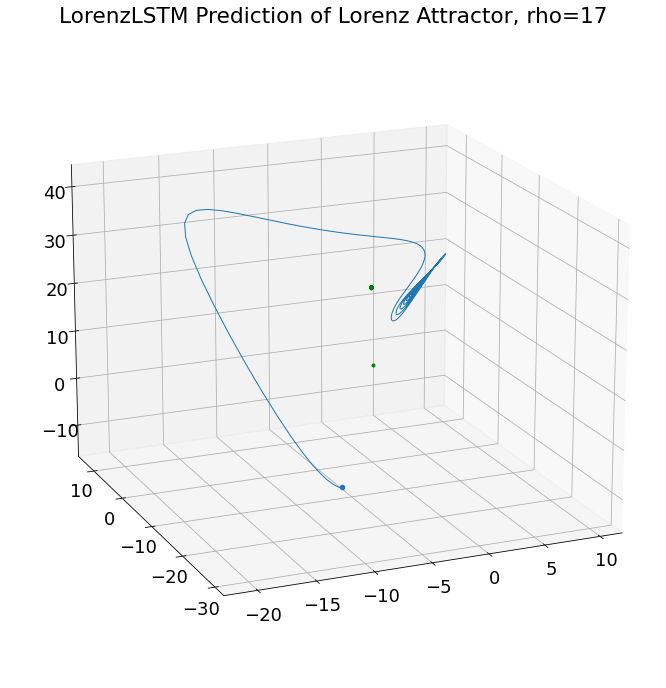

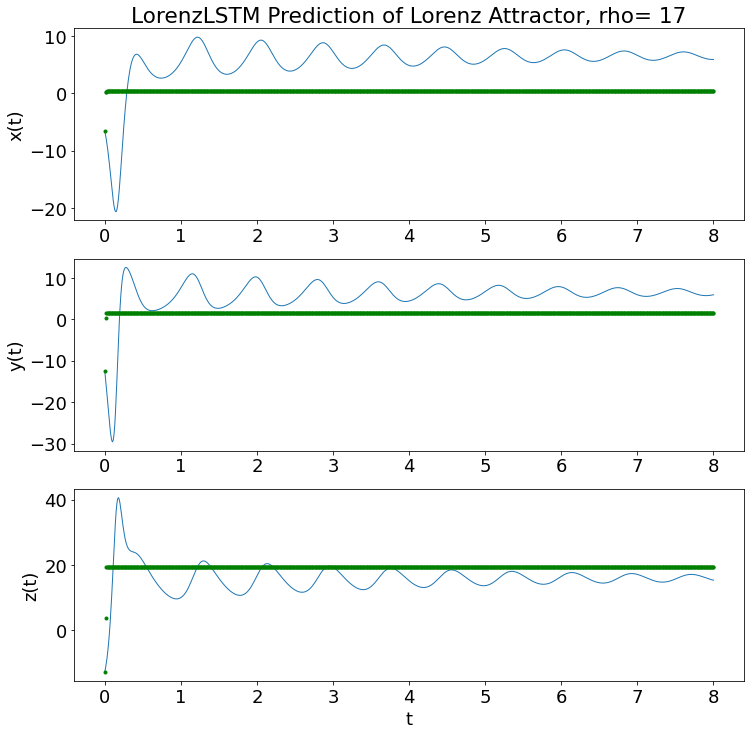

x0     : [-10.94872196  -8.77685618  -3.83738591]
predict: [ 0.32371336  1.61648118 19.44114113]
actual : [13.08981788  9.38852804 42.4748857 ]
predict: [ 0.32371336  1.61648118 19.44114113]
actual : [ 4.2318983   7.11745865 19.4855665 ]
predict: [ 0.32371336  1.61648118 19.44114113]
actual : [-16.85738435  -8.86721763  51.0377931 ]
predict: [ 0.32371336  1.61648118 19.44114113]
actual : [ 4.21732434  7.2127527  18.98853335]
predict: [ 0.32371336  1.61648118 19.44114113]
actual : [-13.35527366  -1.93503776  48.40706596]
predict: [ 0.32371336  1.61648118 19.44114113]
actual : [ 1.33511852  2.30398632 16.90966602]
predict: [ 0.32371336  1.61648118 19.44114113]
actual : [-10.15686146  -3.95648038  40.90910042]
predict: [ 0.32371336  1.61648118 19.44114113]
actual : [-4.34735082 -7.83123782 17.32667685]
(2, 3)
(801, 3)


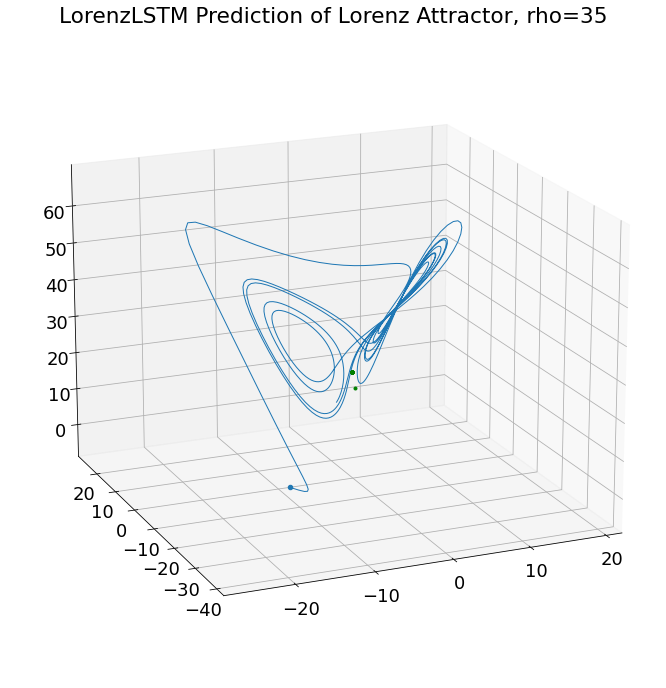

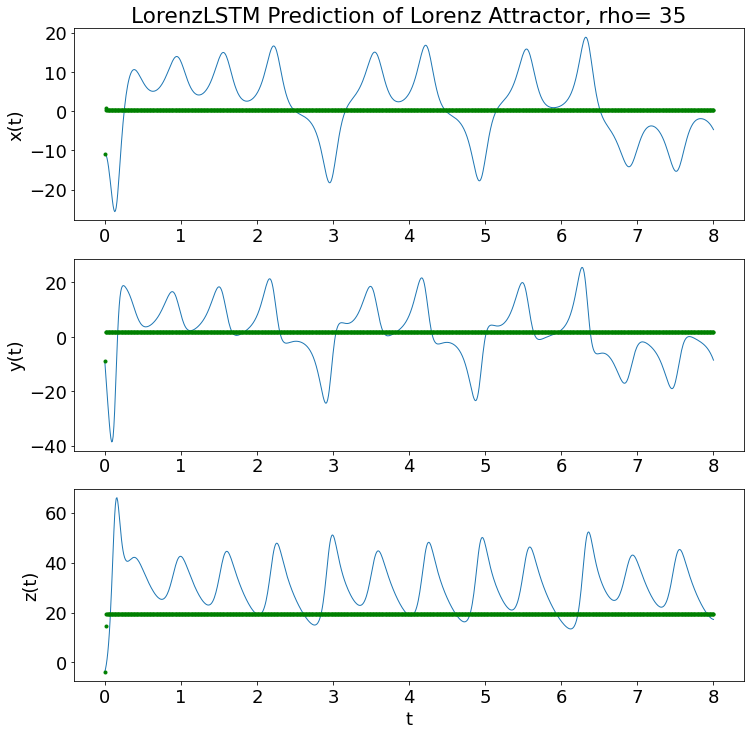

In [60]:
# Now see how well the NN works for future state prediction 
np.random.seed(133) ## Set once before multiple calls to random() function
LSTM_predict(model, rho = 17)
LSTM_predict(model, rho = 35)

In [61]:
class LorenzRNN(nn.Module):
    def __init__(self):
        super(LorenzRNN, self).__init__()
        self.rnn = nn.RNN(input_size=3, hidden_size=64, num_layers=2, batch_first=True)
        self.fc = nn.Linear(64, 3)

    def forward(self, x):
        _, h = self.rnn(x)
        x = self.fc(h[-1])
        return x

batch_size: 128
total_samples: 240000
n_iterations: 1875


c:\Users\Mary\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([128, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 1/100, step 100/1875,  MSELoss=163.3847
epoch 1/100, step 200/1875,  MSELoss=97.4306
epoch 1/100, step 300/1875,  MSELoss=109.2051
epoch 1/100, step 400/1875,  MSELoss=97.6879
epoch 1/100, step 500/1875,  MSELoss=104.7305
epoch 1/100, step 600/1875,  MSELoss=118.2690
epoch 1/100, step 700/1875,  MSELoss=134.8600
epoch 1/100, step 800/1875,  MSELoss=105.9660
epoch 1/100, step 900/1875,  MSELoss=125.0372
epoch 1/100, step 1000/1875,  MSELoss=102.8765
epoch 1/100, step 1100/1875,  MSELoss=97.6397
epoch 1/100, step 1200/1875,  MSELoss=116.6244
epoch 1/100, step 1300/1875,  MSELoss=142.2485
epoch 1/100, step 1400/1875,  MSELoss=122.7671
epoch 1/100, step 1500/1875,  MSELoss=116.4556
epoch 1/100, step 1600/1875,  MSELoss=106.3545
epoch 1/100, step 1700/1875,  MSELoss=107.1255
epoch 1/100, step 1800/1875,  MSELoss=120.6506
epoch 2/100, step 100/1875,  MSELoss=102.9273
epoch 2/100, step 200/1875,  MSELoss=112.4173
epoch 2/100, step 300/1875,  MSELoss=126.2394
epoch 2/100, step 400/1875, 

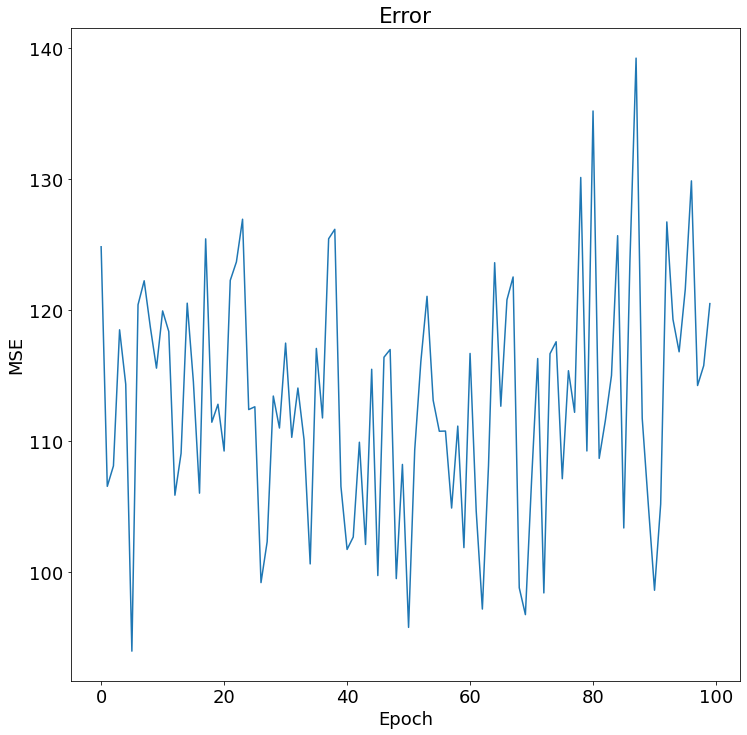

In [62]:
# Train the neural network using all rho_train values
model = LorenzRNN()
model = train_NN(model, input_train=nn_input_train, output_train=nn_output_train, num_epochs=100)

x0     : [ -6.60982767 -12.40678281 -12.80887754]
predict: [ -0.54003614  -0.58294487 -22.646492  ]
actual : [5.20366208 7.30800286 9.87366667]
predict: [ -0.54003614  -0.58294487 -22.646492  ]
actual : [ 8.78465345 10.2451121  16.2073471 ]
predict: [ -0.54003614  -0.58294487 -22.646492  ]
actual : [ 7.44251083  5.5502644  19.47192625]
predict: [ -0.54003614  -0.58294487 -22.646492  ]
actual : [ 4.89965665  4.37743614 15.36302265]
predict: [ -0.54003614  -0.58294487 -22.646492  ]
actual : [ 5.73480499  6.58284684 13.64861062]
predict: [ -0.54003614  -0.58294487 -22.646492  ]
actual : [ 7.47422307  7.85883346 16.37080654]
predict: [ -0.54003614  -0.58294487 -22.646492  ]
actual : [ 6.67139428  5.99455562 17.1649123 ]
predict: [ -0.54003614  -0.58294487 -22.646492  ]
actual : [ 5.89764667  5.8943103  15.3829582 ]
(2, 3)
(801, 3)


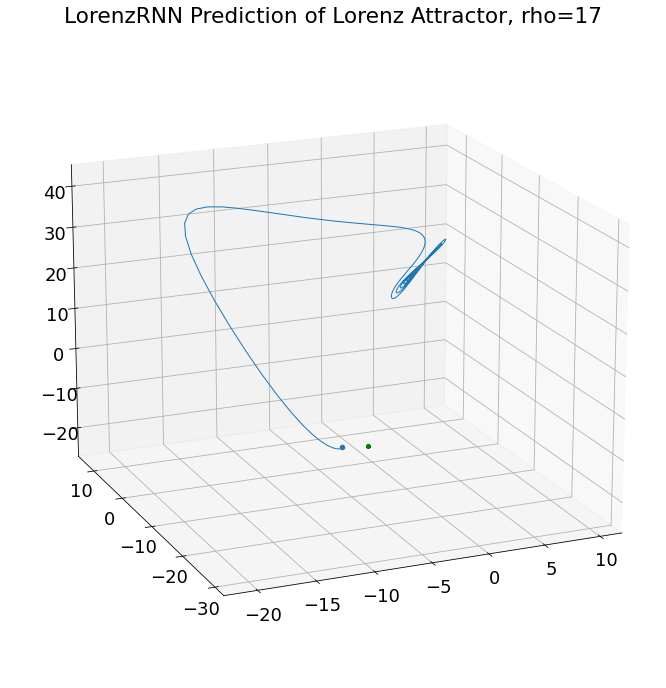

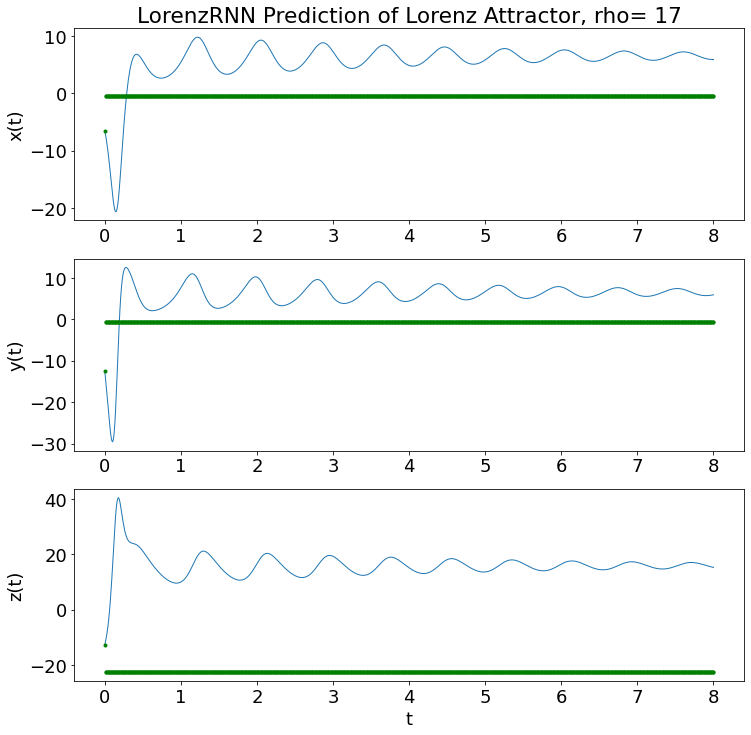

x0     : [-10.94872196  -8.77685618  -3.83738591]
predict: [ -0.54003614  -0.58294487 -22.646492  ]
actual : [13.08981788  9.38852804 42.4748857 ]
predict: [ -0.54003614  -0.58294487 -22.646492  ]
actual : [ 4.2318983   7.11745865 19.4855665 ]
predict: [ -0.54003614  -0.58294487 -22.646492  ]
actual : [-16.85738435  -8.86721763  51.0377931 ]
predict: [ -0.54003614  -0.58294487 -22.646492  ]
actual : [ 4.21732434  7.2127527  18.98853335]
predict: [ -0.54003614  -0.58294487 -22.646492  ]
actual : [-13.35527366  -1.93503776  48.40706596]
predict: [ -0.54003614  -0.58294487 -22.646492  ]
actual : [ 1.33511852  2.30398632 16.90966602]
predict: [ -0.54003614  -0.58294487 -22.646492  ]
actual : [-10.15686146  -3.95648038  40.90910042]
predict: [ -0.54003614  -0.58294487 -22.646492  ]
actual : [-4.34735082 -7.83123782 17.32667685]
(2, 3)
(801, 3)


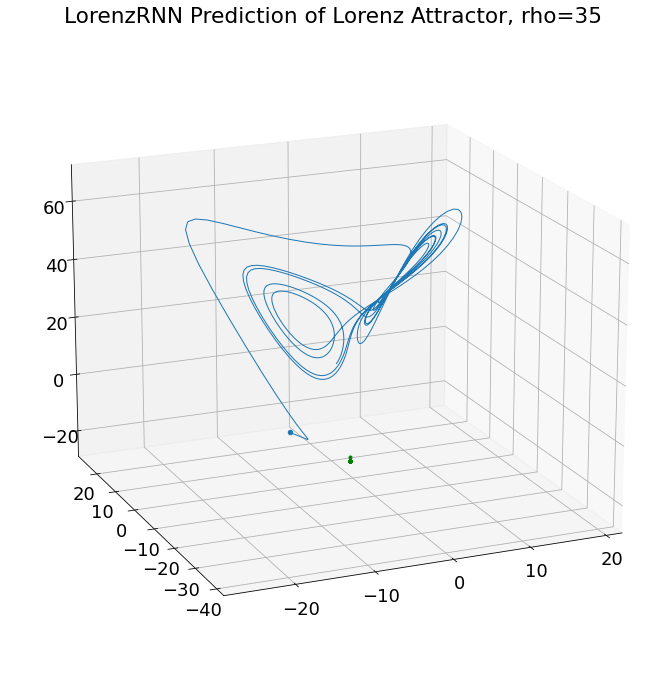

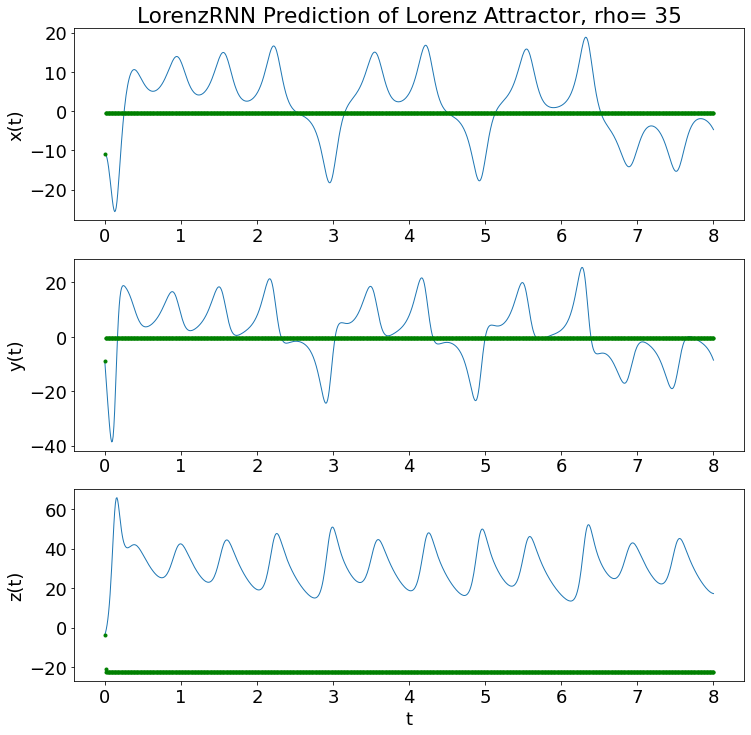

In [65]:
# Now see how well the NN works for future state prediction 
np.random.seed(133) ## Set once before multiple calls to random() function
LSTM_predict(model, rho = 17)
LSTM_predict(model, rho = 35)

In [66]:
!pip install easyesn

  Created wheel for sklearn: filename=sklearn-0.0.post5-py3-none-any.whl size=2971 sha256=f4b2a6468063632aa4015d48e137cbf780ee884b04954a78216c9ab759fbf726
  Stored in directory: c:\users\mary\appdata\local\pip\cache\wheels\36\49\c9\2374f1dee1b599effabf63d948635e6608f62d0ccde027b7e2
Successfully built sklearn


In [72]:
from easyesn.optimizers import GradientOptimizer
from easyesn import PredictionESN
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp

In [93]:
esn = PredictionESN(n_input=1, n_output=1, n_reservoir=50, leakingRate=0.2, regressionParameters=[1e-2], solver="lsqr", feedback=False)
esn.fit(nn_input_train, nn_output_train, transientTime="Auto", verbose=1)

  0% (0 of 719933) |                     | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (0 of 719933) |                     | Elapsed Time: 0:00:11 ETA:  --:--:--
100% (719933 of 719933) |################| Elapsed Time: 0:00:11 Time:  0:00:11


0.6303887688427875

In [94]:
rho = 17
x0 = -15 + 20 * np.random.random((2, 3))
x_t = integrate.odeint(lorenz_deriv, x0[0, :], t, args=(rho, sigma, beta))

ynn = np.zeros((len(t), 3))
ynn[0, :] = x0[0, :]
print("x0     :", ynn[0, :])
with torch.no_grad():
    y0 = torch.tensor(ynn[0, :], dtype=torch.float32)
    for j in range(len(t) - 1):
        y1 = esn.predict(y0) 
        y0 = y1
        ynn[j + 1, :] = y1.squeeze()
        if (j + 1) % 100 == 0:
            print("predict:", ynn[j + 1, :])
            print("actual :", x_t[j, :])

x0     : [-6.40295607  3.12006919 -2.40950467]
predict: [-0.01442558  9.76391529  3.11271761]
actual : [ 5.73823846  7.98968475 10.45673218]
predict: [ 0.21855037 23.45568045  6.63500659]
actual : [ 9.01737194  9.86016741 17.4321531 ]
predict: [ 0.63862614 28.2808544   5.52830542]
actual : [ 6.84969488  4.97936882 18.93242184]
predict: [ 0.67450978 29.24063501  5.13536217]
actual : [ 4.85219148  4.62292288 14.80744714]
predict: [ 0.68055365 29.37162837  5.06837413]
actual : [ 6.07764949  7.01088618 13.87398448]
predict: [ 0.68135035 29.3877973   5.05966191]
actual : [ 7.52002924  7.63035251 16.83961981]
predict: [ 0.68144858 29.38977066  5.05859085]
actual : [ 6.43694735  5.80812908 16.87885149]
predict: [ 0.68146057 29.3900112   5.05846017]
actual : [ 5.94724629  6.0680904  15.21961449]


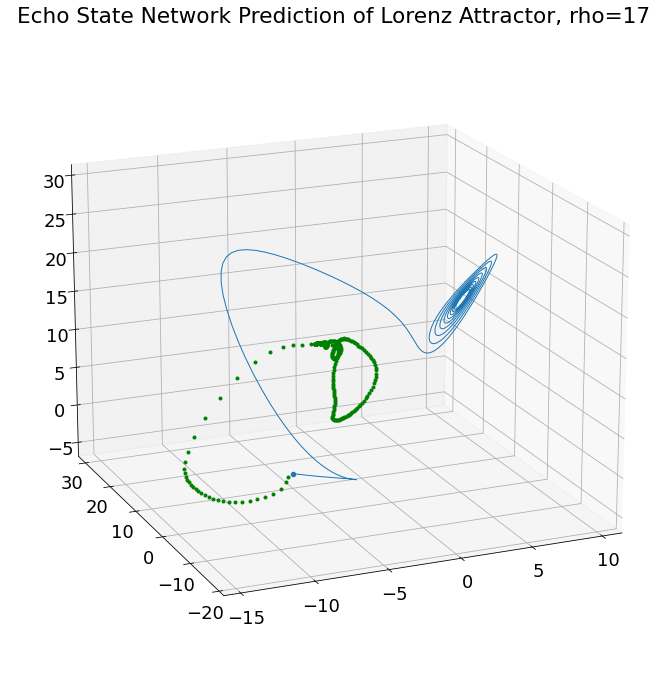

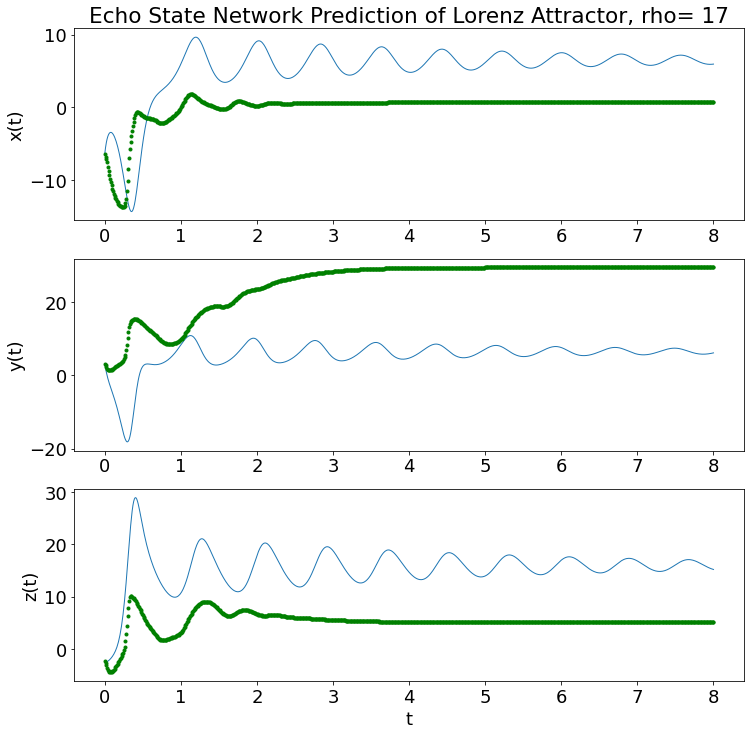

In [95]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_t[:, 0], x_t[:, 1], x_t[:, 2], linewidth=1)
ax.plot(ynn[:, 0], ynn[:, 1], ynn[:, 2], "g.")
ax.scatter(x0[0, 0], x0[0, 1], x0[0, 2], "r")
plt.title(
    "Echo State Network Prediction of Lorenz Attractor, rho=" + str(rho)
)
ax.view_init(18, -113)
plt.show()

fig = plt.figure()

ax = fig.add_subplot(3, 1, 1)
ax.plot(t, x_t[:, 0], linewidth=1)
ax.plot(t, ynn[:, 0], "g.")
plt.title("Echo State Network Prediction of Lorenz Attractor, rho= " + str(rho))
ax.set_ylabel("x(t)")

ax = fig.add_subplot(3, 1, 2)
ax.plot(t, x_t[:, 1], linewidth=1)
ax.plot(t, ynn[:, 1], "g.")
ax.set_ylabel("y(t)")

ax = fig.add_subplot(3, 1, 3)
ax.plot(t, x_t[:, 2], linewidth=1)
ax.plot(t, ynn[:, 2], "g.")
ax.set_ylabel("z(t)")
ax.set_xlabel("t")
plt.show()

In [96]:
rho = 35
x0 = -15 + 20 * np.random.random((2, 3))
x_t = integrate.odeint(lorenz_deriv, x0[0, :], t, args=(rho, sigma, beta))

ynn = np.zeros((len(t), 3))
ynn[0, :] = x0[0, :]
print("x0     :", ynn[0, :])
with torch.no_grad():
    y0 = torch.tensor(ynn[0, :], dtype=torch.float32)
    for j in range(len(t) - 1):
        y1 = esn.predict(y0) 
        y0 = y1
        ynn[j + 1, :] = y1.squeeze()
        if (j + 1) % 100 == 0:
            print("predict:", ynn[j + 1, :])
            print("actual :", x_t[j, :])

x0     : [ 0.66378417 -0.18367718 -5.35332565]
predict: [26.50712184 30.51470547  0.86922608]
actual : [ -8.03142121 -10.7267137   28.01382823]
predict: [27.50004694 27.88512128  1.48991219]
actual : [-5.3041534  -3.94607469 30.6637381 ]
predict: [27.93398461 27.42110423  1.50246888]
actual : [-14.59118696 -10.82668578  44.62234349]
predict: [28.06098132 27.28349227  1.50621744]
actual : [ 1.79004436  3.36150709 21.73494775]
predict: [28.09819816 27.24295238  1.50730822]
actual : [-16.62906666 -13.89298943  46.83424077]
predict: [28.10911721 27.23103994  1.50762756]
actual : [-2.42636107 -4.56815057 24.43381235]
predict: [28.11232187 27.22754212  1.50772122]
actual : [ -8.4679281  -16.81050801  15.10897729]
predict: [28.11326252 27.22651529  1.50774871]
actual : [ 4.89856918  5.91621629 26.13697705]


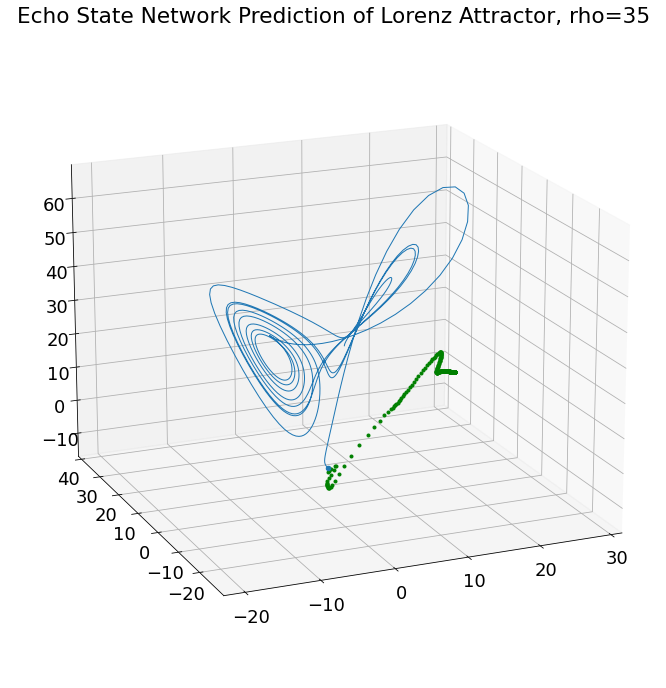

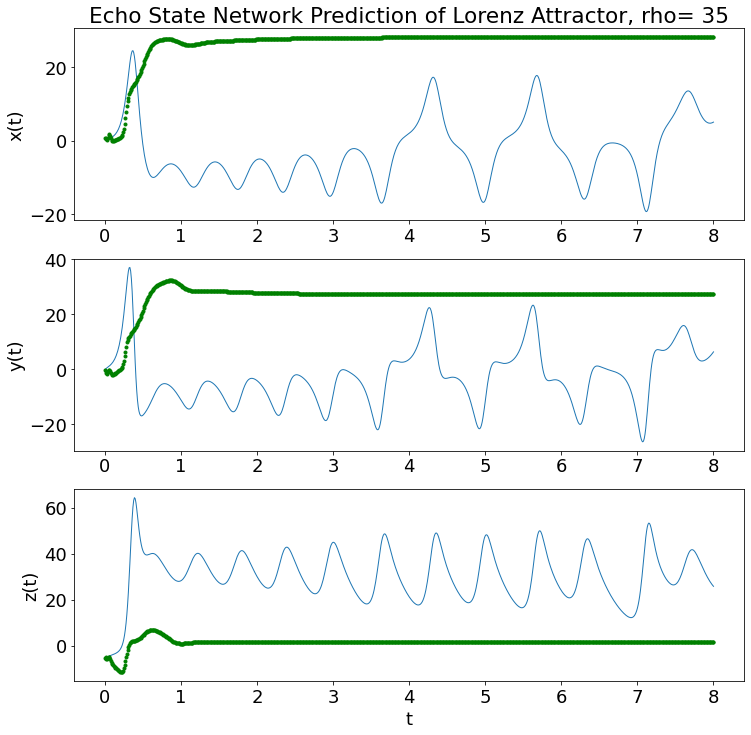

In [97]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_t[:, 0], x_t[:, 1], x_t[:, 2], linewidth=1)
ax.plot(ynn[:, 0], ynn[:, 1], ynn[:, 2], "g.")
ax.scatter(x0[0, 0], x0[0, 1], x0[0, 2], "r")
plt.title(
    "Echo State Network Prediction of Lorenz Attractor, rho=" + str(rho)
)
ax.view_init(18, -113)
plt.show()

fig = plt.figure()

ax = fig.add_subplot(3, 1, 1)
ax.plot(t, x_t[:, 0], linewidth=1)
ax.plot(t, ynn[:, 0], "g.")
plt.title("Echo State Network Prediction of Lorenz Attractor, rho= " + str(rho))
ax.set_ylabel("x(t)")

ax = fig.add_subplot(3, 1, 2)
ax.plot(t, x_t[:, 1], linewidth=1)
ax.plot(t, ynn[:, 1], "g.")
ax.set_ylabel("y(t)")

ax = fig.add_subplot(3, 1, 3)
ax.plot(t, x_t[:, 2], linewidth=1)
ax.plot(t, ynn[:, 2], "g.")
ax.set_ylabel("z(t)")
ax.set_xlabel("t")
plt.show()